# **Facial Expression Recognition fer2013 Challenge**

## **Introduction:**
#### This notebook demonstrates Facial Expression recognition using Convolutional Neural Networks on the fer2013 dataset.

# **Dataset**
#### We use the MNIST Digit Recognition Dataset, to correctly identify digits from a dataset of tens of thousands of handwritten images - [Dataset Link](https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge)

# **Importing Necessary Libraries and Datset**

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Data Exploration + Gathering**

In [2]:
data = pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [4]:
# So we have Training data count: 28709 
# Public Test data count: 3589
# Private Test  data count: 3589

In [5]:
data['emotion'].value_counts() # Total number of labels/emotions

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [6]:
labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
# Fetch the Data

train = data.loc[data["Usage"] == "Training"]
public_test = data.loc[data["Usage"] == "PublicTest"]
private_test = data.loc[data["Usage"] == "PrivateTest"]

print("Training set shape = ", train.shape)
print("PublicTest set shape = ", public_test.shape)
print("PrivateTest set shape = ", private_test.shape)

Training set shape =  (28709, 3)
PublicTest set shape =  (3589, 3)
PrivateTest set shape =  (3589, 3)


/tmp/ipykernel_28/3158020668.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


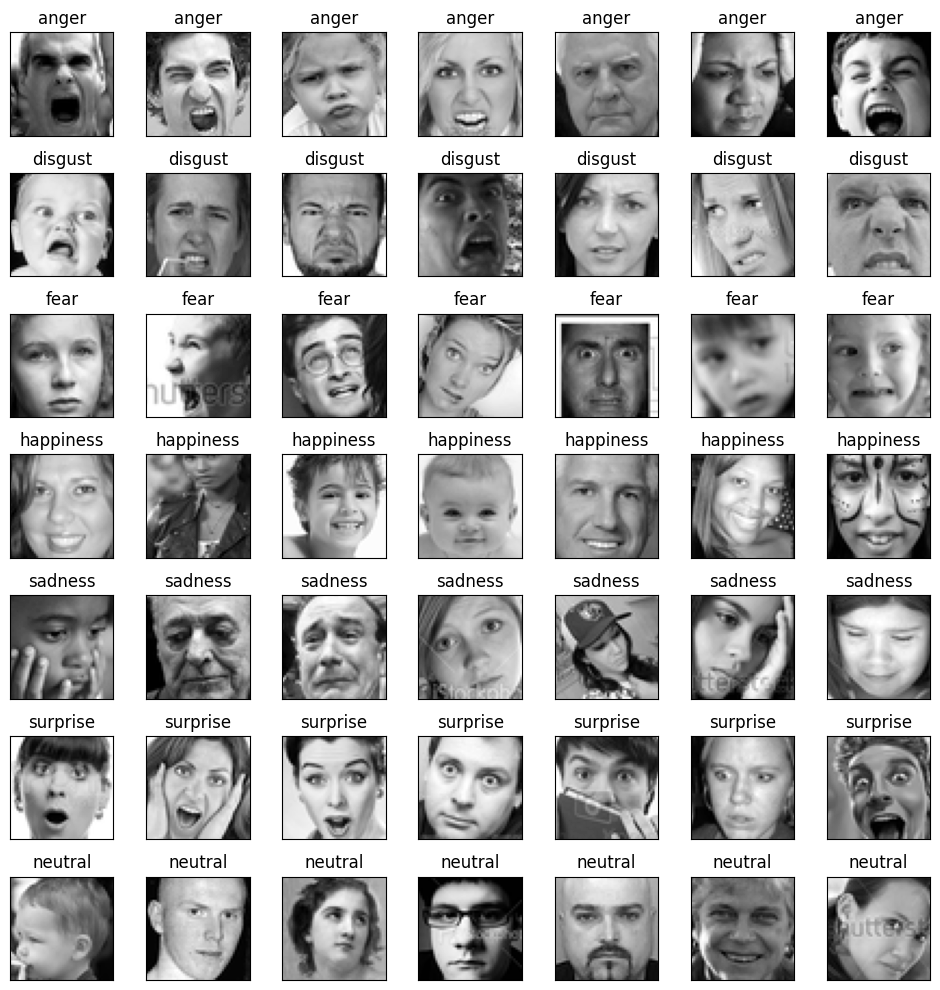

In [8]:
# Let's view some of the data
import random

fig = plt.figure(figsize=(10,10))
c = 0
k = random.randint(0, 500)

for label in sorted(data.emotion.unique()):
    for i in range(len(data.emotion.unique())):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')

        c += 1
        k += 1
        ax = plt.subplot(7, 7, c)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[label])
        plt.tight_layout()

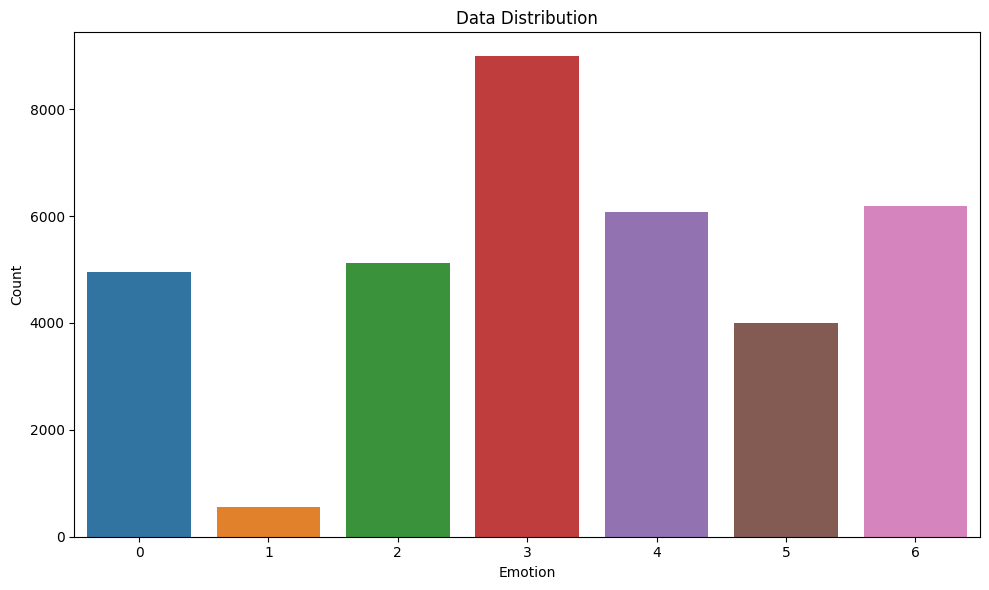

In [9]:
# Look at the data distribution to check for data imbalance

plt.figure(figsize=(10, 6))  
   
sns.countplot(data=data, x="emotion")  
plt.title("Data Distribution")  
plt.xlabel("Emotion") 
plt.ylabel("Count")                 
plt.tight_layout()           
plt.show()  

In [10]:
# Okay, we have a heavy imbalance when it comes to class 1 and 5, in comparison to others with respect to 3

# Let's proceed and see how the model performs without handling data imbalance

# *Set conditions for optimal GPU usage by tensorflow*

In [11]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


# **Getting Data Ready for Training**

In [12]:
# Get labels and convert labels to categorical - Binary Matrix or One Hot Encodings

train_labels = train["emotion"]
y_train = tf.keras.utils.to_categorical(train_labels)

# Get pixels, reshape the images and normalize them (make pixel values between 0 and 1)

train_pixels = train["pixels"].str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
train_pixels = train_pixels.reshape((28709, 48,48))
train_pixels = train_pixels.astype("float32") / 255.
train_pixels = np.array(train_pixels)

In [13]:
# Get labels and convert labels to categorical - Binary Matrix or One Hot Encodings

public_test_labels = public_test["emotion"]
y_val = tf.keras.utils.to_categorical(public_test_labels)

# Get pixels, reshape the images and normalize them (make pixel values between 0 and 1)

public_test_pixels = public_test["pixels"].str.split(" ").tolist()
public_test_pixels = np.uint8(public_test_pixels)
public_test_pixels = public_test_pixels.reshape((3589, 48,48))
public_test_pixels = public_test_pixels.astype("float32") / 255.
public_test_pixels = np.array(public_test_pixels)

In [14]:
# Get labels and convert labels to categorical - Binary Matrix or One Hot Encodings

private_test_labels = private_test["emotion"]
y_test = tf.keras.utils.to_categorical(private_test_labels)

# Get pixels, reshape the images and normalize them (make pixel values between 0 and 1)

private_test_pixels = private_test["pixels"].str.split(" ").tolist()
private_test_pixels = np.uint8(private_test_pixels)
private_test_pixels = private_test_pixels.reshape((3589, 48,48))
private_test_pixels = private_test_pixels.astype("float32") / 255.
private_test_pixels = np.array(private_test_pixels)

In [15]:
X_train = []

for i in range(len(train_pixels)):
    temp = cv2.cvtColor(train_pixels[i], cv2.COLOR_GRAY2RGB)
    X_train.append(temp)

X_train = np.array(X_train)
print(X_train.shape)

(28709, 48, 48, 3)


In [16]:
X_val = []

for i in range(len(public_test_pixels)):
    temp = cv2.cvtColor(public_test_pixels [i], cv2.COLOR_GRAY2RGB)
    X_val.append(temp)

X_val = np.array(X_val)
print(X_val.shape)

(3589, 48, 48, 3)


In [17]:
X_test = []

for i in range(len(private_test_pixels )):
    temp = cv2.cvtColor(private_test_pixels  [i], cv2.COLOR_GRAY2RGB)
    X_test.append(temp)

X_test = np.array(X_test)
print(X_test.shape)

(3589, 48, 48, 3)


In [18]:
# Create Image Data Generator

batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 8,
                                                       width_shift_range = 0.1,
                                                       height_shift_range = 0.1,
                                                       shear_range = 0.1,
                                                       zoom_range = 0.1,
                                                       horizontal_flip = True)


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = datagen.flow(X_val, y_val, batch_size=batch_size)

# **Data has been Preprocessed and Loaded. Next is Model creation and Training**

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers as L

def create_model():
    base_model = VGG16(include_top = False)
    base_model.trainable = False
    
    for layer in base_model.layers[-5:]:
        layer.trainable = True
        
    Inputs = L.Input(shape=(48,48,3))
    x = base_model(Inputs)
    x = L.Flatten()(x)
    Outputs = L.Dense(len(data.emotion.unique()), activation="softmax")(x)
    
    model = tf.keras.models.Model(Inputs, Outputs, name="VGG16")
    
    return model

In [20]:
# Create the model

with strategy.scope():
    model = create_model()
    model.compile(loss="categorical_crossentropy", 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                 metrics=["accuracy"])

print(model.input_shape, model.output_shape)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
(None, 48, 48, 3) (None, 7)
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
# Callbacks for the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1, restore_best_weights = True),
           ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 3, min_lr = 1e-6, verbose = 1,)]

In [ ]:
history = model.fit(train_gen, 
                  epochs = 50, 
                  batch_size = batch_size,
                  validation_data = val_gen,
                  callbacks=callbacks,
                  use_multiprocessing = True)